# Eclipse model

The eclipse model, `pytransit.EclipseModel`, can be used to model a secondary eclipse. The model is similar to ``pytransit.UniformModel``, but the eclipse occurs correctly where it should based on the orbital eccentricity and argument of periastron, and the model takes the planet-star flux ratio as an additional free parameter. The model is parallelised using numba, and the number of threads can be set using the `NUMBA_NUM_THREADS` environment variable. 

In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.append('..')

In [3]:
from pytransit import EclipseModel

In [4]:
seed(0)

times_sc = linspace(0.5, 2.5, 5000)  # Short cadence time stamps
times_lc = linspace(0.5, 2.5,  500)  # Long cadence time stamps

k, t0, p, a, i, e, w  = 0.1, 1., 2.0, 4.2, 0.5*pi, 0.25, 0.4*pi

ns = 50
ks = normal(k, 0.01, ns)
t0s = normal(t0, 1e-5, ns)
ps = normal(p, 1e-5, ns)
aas = normal(a, 0.01, ns)
iis = normal(i, 1e-5, ns)
es = uniform(0, 0.3, ns)
ws = uniform(0, 2*pi, ns)
frs = normal(0.01, 1e-5, ns)

## Model initialization

The eclipse model doesn't take any special initialization arguments, so the initialization is straightforward. 

In [5]:
tm = EclipseModel()

## Data setup
### Homogeneous time series

The model needs to be set up by calling `set_data()` before it can be used. At its simplest, `set_data` takes the mid-exposure times of the time series to be modelled.

In [6]:
tm.set_data(times_sc)

## Model use

**Evaluation**
The transit model can be evaluated using either a set of scalar parameters, a parameter vector (1D ndarray), or a parameter vector array (2D ndarray). The model flux is returned as a 1D ndarray in the first two cases, and a 2D ndarray in the last (one model per parameter vector).

  - `tm.evaluate_ps(k, t0, p, a, i, e=0, w=0)` evaluates the model for a set of scalar parameters, where `k` is the radius ratio, `t0` the zero epoch, `p` the orbital period, `a` the semi-major axis divided by the stellar radius, `i` the inclination in radians, `e` the eccentricity, and `w` the argument of periastron. Eccentricity and argument of periastron are optional, and omitting them defaults to a circular orbit. 
  - `tm.evaluate_pv(pv)` evaluates the model for a 1D parameter vector, or 2D array of parameter vectors. In the first case, the parameter vector should be array-like with elements `[k, t0, p, a, i, e, w]`. In the second case, the parameter vectors should be stored in a 2d ndarray with shape `(npv, 7)` as 


    [[k1, t01, p1, a1, i1, e1, w1],
     [k2, t02, p2, a2, i2, e2, w2],
     ...
     [kn, t0n, pn, an, in, en, wn]]
     
The reason for the different options is that the model implementations may have optimisations that make the model evaluation for a set of parameter vectors much faster than if computing them separately. This is especially the case for the OpenCL models.


In [7]:
def plot_transits(tm, fmt='k', tc_label=True):
    fig, axs = subplots(1, 2, figsize = (13,3), constrained_layout=True, sharey=True)

    flux = tm.evaluate_ps(k, t0, p, a, i, e, w)
    axs[0].plot(tm.time, flux, fmt)
    axs[0].set_title('Individual parameters')

    flux = tm.evaluate(ks, t0s, ps, aas, iis, es, ws)
    axs[1].plot(tm.time, flux.T, fmt, alpha=0.2)
    axs[1].set_title('Parameter vector')

    if tc_label:
        for ax in axs:
            ax.axvline(t0, c='k', ls='--')
            ax.text(t0-0.01, 0.999, 'Transit centre', rotation=90, va='top', ha='right')
    
    setp(axs[0], ylabel='Normalised flux')
    setp(axs, xlabel='Time [days]', xlim=tm.time[[0,-1]])

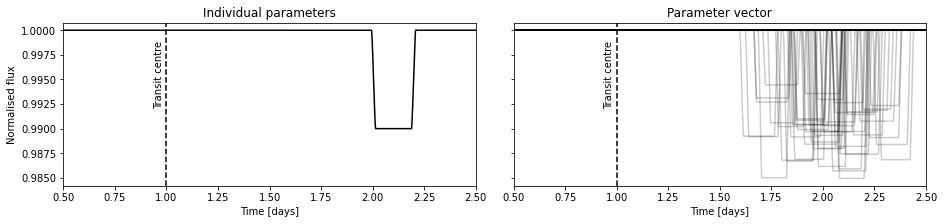

In [8]:
tm.set_data(times_sc)
plot_transits(tm)

## Supersampling

The eclipse model can be supersampled by setting the `nsamples` and `exptimes` arguments in `set_data`.

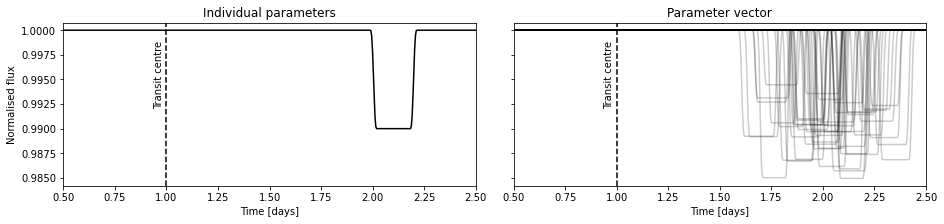

In [9]:
tm.set_data(times_lc, nsamples=10, exptimes=0.01)
plot_transits(tm)

## Heterogeneous time series

PyTransit allows for heterogeneous time series, that is, a single time series can contain several individual light curves (with, e.g., different time cadences and required supersampling rates) observed (possibly) in different passbands.

If a time series contains several light curves, it also needs the light curve indices for each exposure. These are given through `lcids` argument, which should be an array of integers. If the time series contains light curves observed in different passbands, the passband indices need to be given through `pbids` argument as an integer array, one per light curve. Supersampling can also be defined on per-light curve basis by giving the `nsamples`and `exptimes` as arrays with one value per light curve. 

For example, a set of three light curves, two observed in one passband and the third in another passband

    times_1 (lc = 0, pb = 0, sc) = [1, 2, 3, 4]
    times_2 (lc = 1, pb = 0, lc) = [3, 4]
    times_3 (lc = 2, pb = 1, sc) = [1, 5, 6]
    
Would be set up as

    tm.set_data(time  = [1, 2, 3, 4, 3, 4, 1, 5, 6], 
                lcids = [0, 0, 0, 0, 1, 1, 2, 2, 2], 
                pbids = [0, 0, 1],
                nsamples = [  1,  10,   1],
                exptimes = [0.1, 1.0, 0.1])
                
                
### Example: two light curves with different cadences

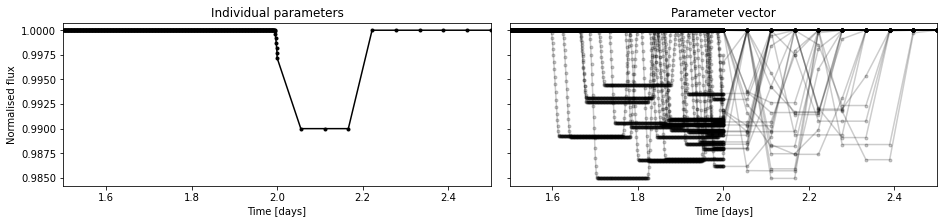

In [10]:
times_1 = linspace(1.5, 2.0, 500)
times_2 = linspace(2.0, 2.5,  10)
times = concatenate([times_1, times_2])
lcids = concatenate([full(times_1.size, 0, 'int'), full(times_2.size, 1, 'int')])
nsamples = [1, 10]
exptimes = [0, 0.0167]

tm.set_data(times, lcids, nsamples=nsamples, exptimes=exptimes)
plot_transits(tm, 'k.-', tc_label=False)

---
<center>&copy; Hannu Parviainen 2010-2020</center>